# Fine-Tuning Lab

Welcome to the fine-tuning lab! By the end of this lab, you will have

1. Loaded a pretrained network and ask it for predictions
2. Trained a logistic model on top of a frozen pretrained network to predict cats from dogs
3. Fine-tuned a pretrained network to predict cats from dogs
4. Performed error analysis to get insight into next steps to take

Let's get started!

---

# Pretrained Networks

In this section, we will practice using a pretrained model, in particular `VGGNet`. `VGGNet` won the 2013 [*ImageNet Large Scale Visual Recognition Challenge (ILSVRC)*](http://image-net.org/challenges/LSVRC/2013/). After loading `VGGNet`, we will have it to make predictions on our images. We will then modify it so that it is tailored to the cats vs. dogs dataset.

# Loading a Pre-Trained `VGGNet` in `keras`

![VGGNet](http://machinethink.net/images/vggnet-convolutional-neural-network-iphone/VGGNet@2x.png)

Keras provides a simple and easy way of loading in a pretrained `VGGNet` for us to play around with.

## Tasks

- Instantiate a `keras.applications.VGG16` model with `ImageNet` pretrained weights
- Use `keras.models.Model.summary()` to visualize the architecture

## Hints

- [Documentation](https://keras.io/applications/#vgg16) for `keras.applications.VGG16`
- Check out the example **Extract features with VGG16** on the `keras` [applications](https://keras.io/applications/) page for how to load a `VGG16` model with pretrained `ImageNet` weights

## Notes

- The first time you instantiate a `keras.applications.vgg16.VGG16` with ImageNet weights keras will download the weights which might take some time so be patient!

In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Task

- Download the file `CatsVDogs.p` and put it in an accessible directory and load the data into memory

In [3]:
import pickle

imgs, y = pickle.load(open('data/CatsVDogsSmall.p', 'rb'))

# Preprocessing Images

Even though the cats vs. dogs dataset has different labels than those found in `ImageNet`, we can still ask `VGGNet` to make predictions and output the most likely `ImageNet` classes. But before doing this, we need to perform the necessary preprocessing the VGGNet expects.

### Tasks

- Convert `imgs` to a `4D` `numpy` array and save it to a variable named `X`
- Perform the preprocessing on `X` that `VGGNet16` expects
- Display five prepocessed images

### Hints

- Use `keras.applications.vgg16.preprocess_input()` to zero-center a 4D tensor of images with respect to the mean RGB value in `ImageNet`

In [27]:
import numpy as np
from IPython.display import display
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
    
X_tf = np.array([img_to_array(img) for img in imgs])
X_tf = preprocess_input(X_tf)

X_tf.shape

(2000, 224, 224, 3)

## Question

- What does `keras.applications.vgg16.preprocess_input()` do?

## Hint

- Look at how and where [`keras.applications.vgg16.preprocess_input()`](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py#L27) is defined

## Answer

- The color channels are shifted and then the mean pixel intensity is subtracted channel-wise.

# `VGGNet` Predictions

Let's make some predictions with our VGGNet.

## Tasks

- Use `keras.applications.vgg16.predict()` to make predictions on the first four images of `X`
- Use `keras.applications.vgg16.decode_predictions()` to recover the object class names from the `VGGNet` predictions
- Display the first four images along with `VGGNet`'s predictions

## Hints

- Look at the `keras` [applications](https://keras.io/applications/) page for an example of making predictions with `VGGNet`

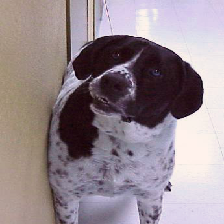

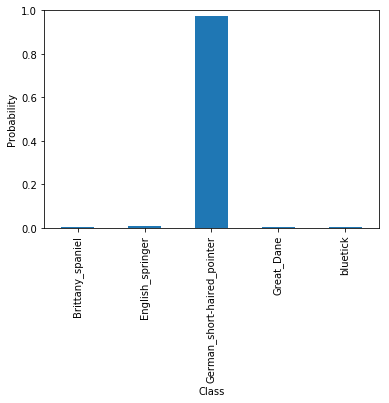

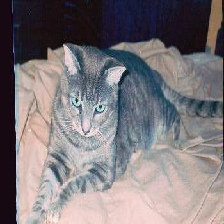

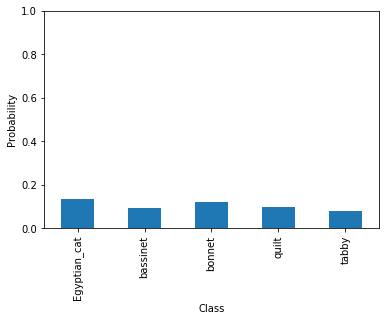

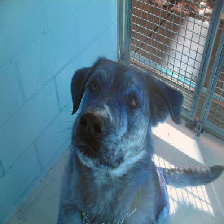

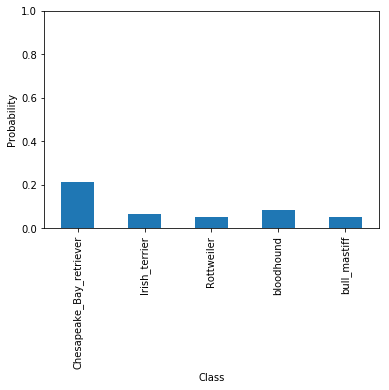

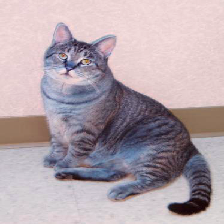

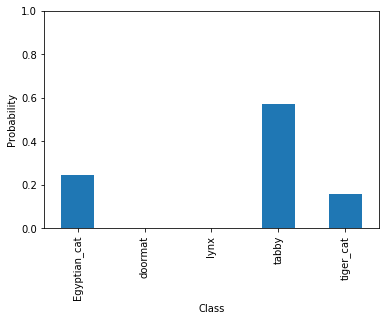

In [30]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import array_to_img

y_pred = model.predict(X_tf[:4])
y_pred = decode_predictions(y_pred)

for x, probas in zip(X_tf, y_pred):
    img = array_to_img(x)
    display(img)
    
    s = pd.Series(dict((name, proba) for id, name, proba in probas))
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

We see that `VGGNet` does a fairly good job at predicting sensibly classes. However, a lot of modeling effort is wasted by predicting probabilities for 1,000Â classes when all we care about are *two* classes (i.e. cat and dog). In other words, `VGGNet` is not tailored to our specific dataset.

# Training a Classifier with `VGGNet` Features

Let's tailor `VGGNet` to the cats vs. dogs dataset by treating `VGGNet` as a black-box feature extractor train a logistic classifier on top.

### Tasks

- Replace the 1000-unit Dense+Softmax layer on `keras.applications.vgg16` with a `1`-unit Dense+Sigmoid layer
- Use `keras.models.Model.summary()` to ensure that you've successfully replaced the `1,000`-way softmax layer with a dense layer followed by a sigmoid activation

### Hints

- Look at the **Fine-tune InceptionV3 on a new set of classes** example on the `keras` [applications](https://keras.io/applications/) page for an example of how to modify the final layers of a `keras.models.Model`

In [35]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')

fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=1, activation='sigmoid')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/edward.banner/.anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
/Users/edward.banner/.anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


# Freeze Base Model

We want to treat `VGGNet` as a fixed feature extractor and optimize only the weights in the final Dense layer.

## Tasks

- Set the `trainable` attribute on every `keras.layers.Layer` to `False` for every layer except the last dense layer in the `keras.models.Model`
- Print out the name of each `keras.layers.Layer` with the value of its `trainable` attribute to ensure you've been successful

## Hints

- The `keras.models.Model.layers` attribute provides access the layers in a `keras` model
- The `keras.layers.Layer.name` attribute contains the name of a layer
- `keras.layers.Layer.trainable = False` freezes that layer during training

## Reminder

- Make sure to compile your model after freezing weights for it to really take effect!

In [45]:
for layer in model.layers[:-1]:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

# Train Dense Layer on Cats vs. Dogs Dataset

It's time we learn the parameters of our newly defined dense layer on the cats vs. dogs dataset!

## Tasks

- Compile the `keras.models.Model`
- Call `keras.models.Model.fit()` with the images and labels for 1 epoch and with a `validation_split=0.1`

## Suggestions

- Kill the training after it finishes the first batch (otherwise it will take forever and our concern here is not overall accuracy but learning)

In [47]:
model.fit(X_tf, y, validation_split=0.1, nb_epoch=1)

/Users/edward.banner/.anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 1800 samples, validate on 200 samples
Epoch 1/1
  64/1800 [>.............................] - ETA: 1675s - loss: 0.6474 - acc: 0.6875

KeyboardInterrupt: 

# Make Predictions

Given a new image, the `keras.models.Model` should now output a single number $p(y = \text{dog}\ |\ x)$.

## Tasks

- Use `keras.models.Model.predict()` on the first four images of `X_tf`
- Display the images along with their predictions

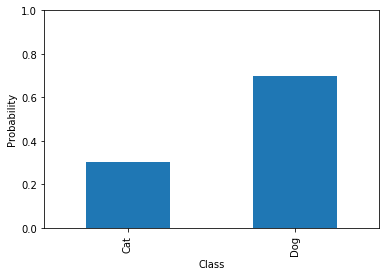

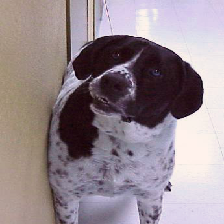

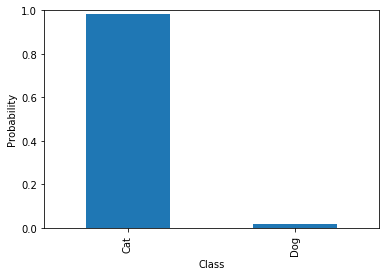

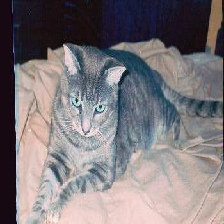

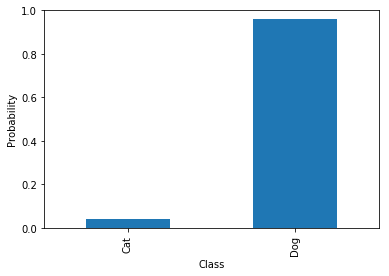

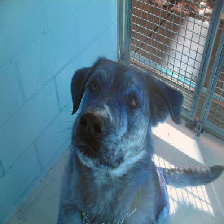

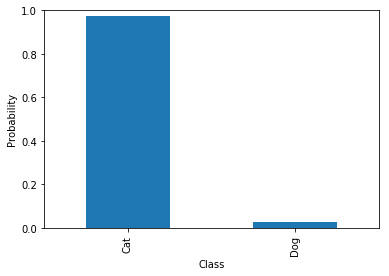

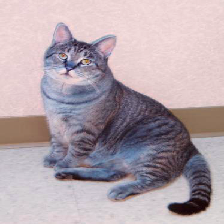

In [48]:
y_pred = model.predict(X_tf[:4])

def show_predictions(X, y_pred):
    """Visualize predictions for images `X`"""
    
    for x, y in zip(X, y_pred.flatten()):
        # Predictions
        s = pd.Series({'Cat': 1-y, 'Dog': y})
        axes = s.plot(kind='bar')
        axes.set_xlabel('Class')
        axes.set_ylabel('Probability')
        axes.set_ylim([0, 1])
        plt.show()

        # Image
        img = array_to_img(x)
        display(img)
        
show_predictions(X_tf, y_pred)

Using `VGGNet` as a black-box feature extractor gets us respectible performance. However, we can do better by leveraging supervised *fine-tuning*, a type of *transfer learning*.

# Fine-Tuning `VGGNet` on Cats vs. Dogs Dataset

In addition to learning the final Dense+Sigmoid layer, we can also update the last few layers of `VGGNet` during training through a process called *fine-tuning*. This process is illustrated in the following figure.

![Fine-Tuning](https://blog.keras.io/img/imgclf/vgg16_modified.png)

# Set Up `VGGNet` for Fine-Tuning

## Tasks

- Unfreeze the penultimate dense layer along with the final conv block
- Print out each layer name with the value of its `trainable` attribute to ensure you've successfully unfrozen the last conv block plus the final two dense layers

## Hints

- Use `keras.models.Model.summary()` to determine the names for the last two `Dense` layers
- Use `keras.models.Model.get_layer()` to get references to these layers
- `keras.layers.Layer.trainable = True` unfreezes a `keras.layers.Layer`

In [61]:
from keras.optimizers import SGD

for layer in model.layers:
    if layer.name not in ['fc1', 'fc2', 'flatten'] and not layer.name.startswith('block5'):
        continue
    model.get_layer(layer.name).trainable = True

df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

# Fine-Tune `VGGNet`

Now that we have unfrozen the last two `Dense` layers and the final conv block we can optimize these weights for even better performance.

## Tasks

- `keras.models.Model.compile()` the model with a stochastic gradient descent optimizer with a small learning rate (e.g. $10^{-4}$)
- `keras.models.Model.fit()` the `keras.models.Model` to the image data with a `validation_split=1` for one epoch

## Suggestions

- Kill the training after a minibatch update since it takes forever on a CPU

In [63]:
from keras.optimizers import SGD

sgd = SGD(lr=1e-4)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_tf, y, epochs=1, validation_split=0.1);

/Users/edward.banner/.anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1800 samples, validate on 200 samples
Epoch 1/1
  64/1800 [>.............................] - ETA: 2154s - loss: 0.3325 - acc: 0.8906

KeyboardInterrupt: 

### Make Predictions with Fine-Tuned `VGGNet`

### Tasks

- `keras.applications.vgg16.predict()` the labels of the first four images in the cats vs. dogs dataset
- `IPython.display.display()` each image with its prediction

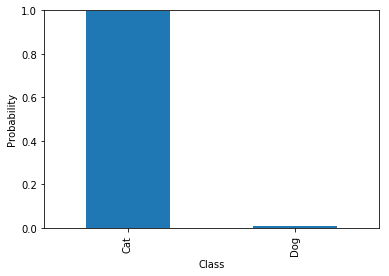

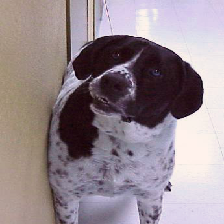

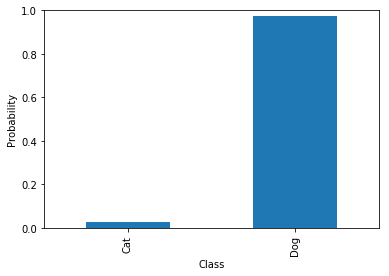

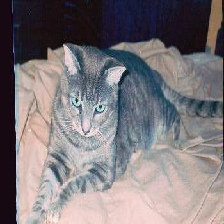

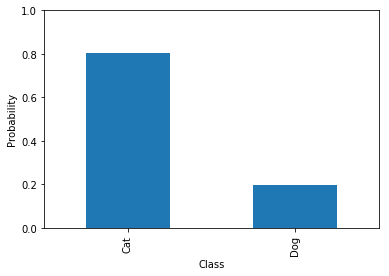

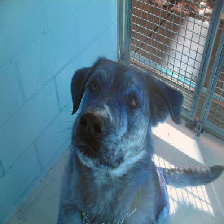

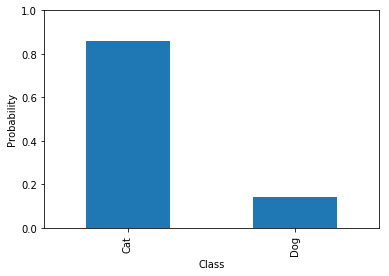

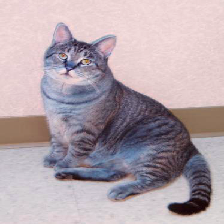

In [64]:
y_pred = model.predict(X[-4:])
        
show_predictions(X_tf, y_pred)

# Bonus Activities

---

# Error Analysis

Now that we have a reasonably performing image classifier, what's next? A good idea is to perform *error analysis* to systemtically discover which types of errors your model is making the most.

## Task

- Make predictions on the first 128 images

## Hint

- Recall that cats have labels of `0`, while dogs have labels of `1`

## Admission

- In a real-world setting you would make predictions on a held-out test set. However, we have not gone through the trouble of creating one and hence using the training set will do this one time.

In [66]:
%%time

probas = model.predict(X_tf[:128]).flatten()

## Task

- Display five images which your model made the correct prediction

0.923507


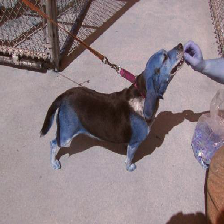

0.331799


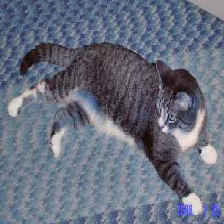

0.163361


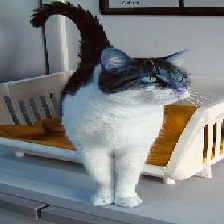

0.100905


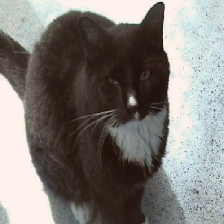

0.0215436


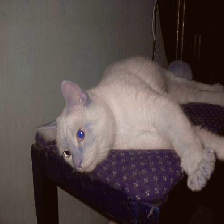

In [83]:
from IPython.display import display
import copy
import numpy as np
from keras.preprocessing.image import array_to_img

y_pred = copy.deepcopy(probas)
cat_mask = y_pred < .5
y_pred[cat_mask], y_pred[~cat_mask] = np.arange(2, dtype=np.int32)

right_mask = (y_pred == y[:128])
right_idxs, wrong_idxs = np.argwhere(right_mask).flatten(), np.argwhere(~right_mask).flatten()

for right_idx in np.random.choice(right_idxs, size=5, replace=False):
    x, proba = X_tf[right_idx], probas[right_idx]
    print(proba)
    img = array_to_img(x)
    display(img)

## Task

- Display five images which your model made an incorrect prediction

0.414798


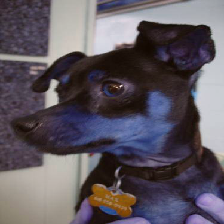

0.398941


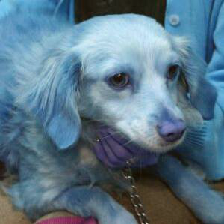

0.421124


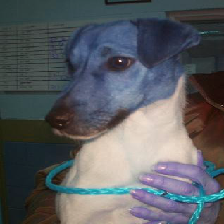

0.22878


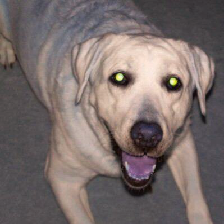

0.404834


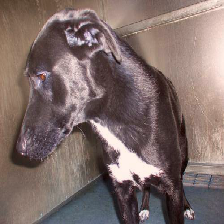

In [84]:
for wrong_idx in np.random.choice(wrong_idxs, size=5, replace=False):
    x, proba = X_tf[wrong_idx], probas[wrong_idx]
    print(proba)
    img = array_to_img(x)
    display(img)

## Task

- Display the top five cat images that your model is very sure contains a cat along with its confidence for each image

0.000168765


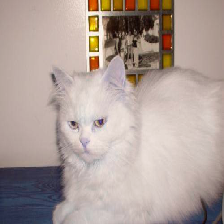

0.000187268


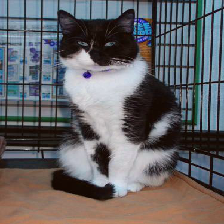

0.00183596


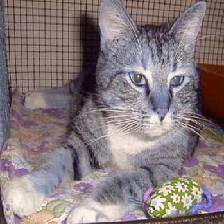

0.00238516


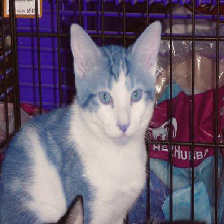

0.00296264


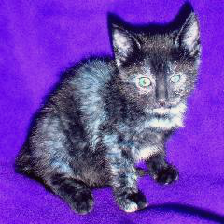

In [87]:
from IPython.display import display

cat_idxs = np.argwhere(y[:128] == 0).flatten()
cat_probas, X_cat = probas[cat_idxs], X_tf[cat_idxs]
ordered_cat_proba_idxs = np.argsort(cat_probas)

for right_cat_idx in ordered_cat_proba_idxs[:5]:
    x, proba = X_cat[right_cat_idx], cat_probas[right_cat_idx]
    print(proba)
    img = array_to_img(x)
    display(img)

## Task

- Display the top five cat images that your model is very sure contains a dog along with its confidence for each image

0.395495


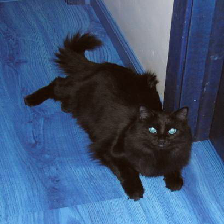

0.427154


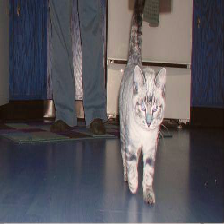

0.670673


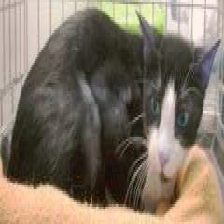

0.783208


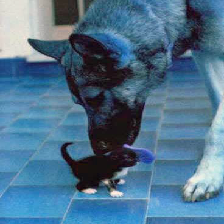

0.933012


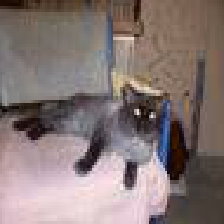

In [88]:
for wrong_cat_idx in ordered_cat_proba_idxs[-5:]:
    x, proba = X_cat[wrong_cat_idx], cat_probas[wrong_cat_idx]
    print(proba)
    img = array_to_img(x)
    display(img)

## Task

- Display the top five images which confuse your model the most along with its confidence for each image

0.52516


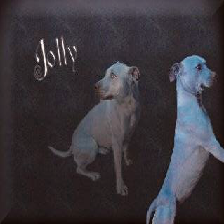

0.459936


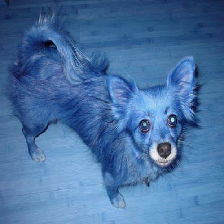

0.457165


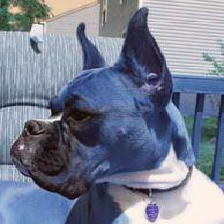

0.544422


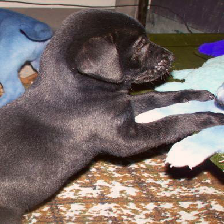

0.54469


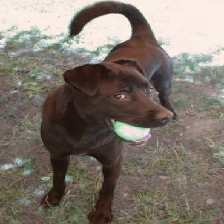

In [90]:
shifted_animal_probas = np.abs(probas - .5)
ordered_confused_proba_idxs = np.argsort(shifted_animal_probas)

for confused_idx in ordered_confused_proba_idxs[:5]:
    x, proba = X_tf[confused_idx], probas[confused_idx]
    print(proba)
    img = array_to_img(x)
    display(img)